In [1]:
library('bnlearn')
library(Rgraphviz);

Loading required package: graph

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:bnlearn’:

    score


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, wh

In [2]:
survey <- read.delim('survey.txt', sep = " ")
net <-  model2network("[A][S][E|A:S][O|E][R|E][T|O:R]")

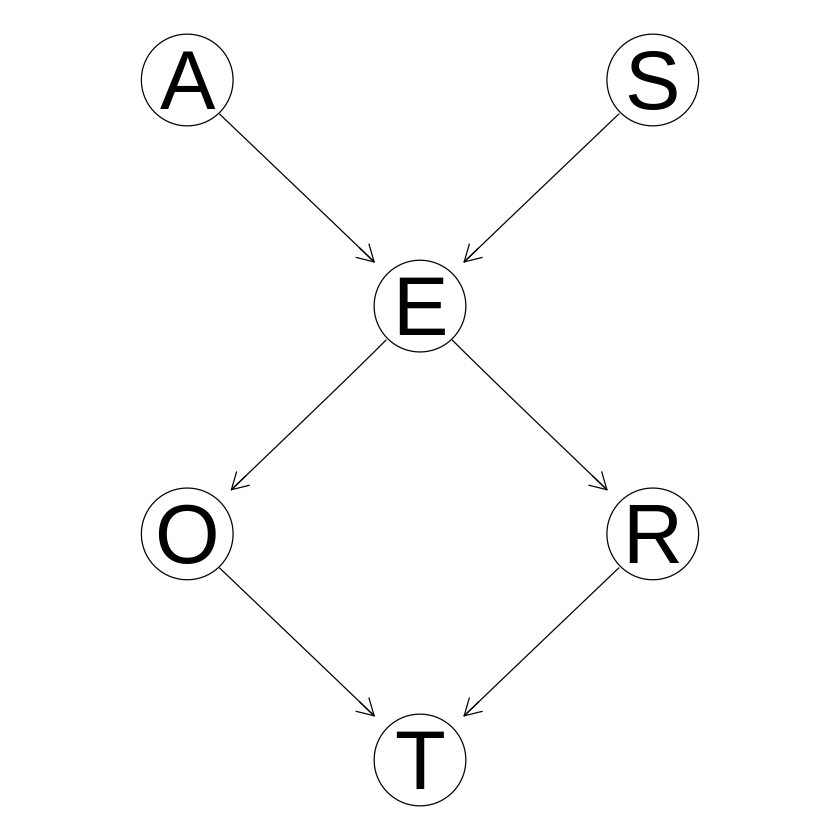

In [3]:
graphviz.plot(net)

In [4]:
d_sep <- bnlearn:::dseparation

In [5]:
d_sep(bn = net, x = 'A', y = 'E', z = c('R', 'T'))

[1] FALSE

In [6]:
vars <- nodes(net)
pairs <- combn(x = vars, 2, list)
arg_sets <- list()
for(pair in pairs){
  others <- setdiff(vars, pair)
  conditioning_sets <- unlist(lapply(0:4, function(.x) combn(others, .x, list)), recursive = F)
  for(set in conditioning_sets){
    args <- list(x = pair[1], y = pair[2], z = set)
    arg_sets <- c(arg_sets, list(args)) 
  }
}

In [7]:
d_separated_sets <- list()
for(i in 1:length(arg_sets)) {
    arg_set <- arg_sets[[i]]
  # i-th element of `u1` squared into `i`-th position of `usq`
        if( d_sep(bn=net, x=arg_set$x, y=arg_set$y, z=arg_set$z)){
            d_separated_sets <- c(d_separated_sets, list(arg_set)) 
        }
}

In [8]:
print(d_separated_sets[[12]])

$x
[1] "A"

$y
[1] "R"

$z
[1] "E" "T"



A and R  are causally independent of each other given E, T

1b. Redundant example : node1 d-separated from node2 given node3 => node1 d-separated from node2 given node3 + any of node3's children, e.g. "A" and "O" are d-separated given E, redudnat statements are any other children of E, e.g. "A" and "O" are d-separated given E and R

In [37]:
redundant_sets <- list()
for(i in 1:(length(d_separated_sets) - 1)) {
    start_set <- d_separated_sets[[i]]
    if(length(start_set$z) == 1){
        for(j in (i+1):length(d_separated_sets)) {
            end_set <- d_separated_sets[[j]]
            if ((start_set$x == end_set$x) & (start_set$y == end_set$y)) {
                setdiff_nodes = setdiff(end_set$z, start_set$z)
                intersect_nodes = intersect(end_set$z, start_set$z)
                is_redundant <- FALSE
                for (node in intersect_nodes) {
                    children_of_node <- children(net, node) 
                    if (length(setdiff(children_of_node, setdiff_nodes)) == 0 ){
                        print('redundant: (1 imples 2)')
                        print('set1')
                        print(c(start_set$x,',', start_set$y,',', start_set$z))
                        print('set2')
                        print(c(end_set$x, ',', end_set$y, ',',end_set$z))
                    }
                }
            }

        }
    }
}

[1] "redundant: (1 imples 2)"
[1] "set1"
[1] "A" "," "T" "," "E"
[1] "set2"
[1] "A" "," "T" "," "E" "O" "R"
[1] "redundant: (1 imples 2)"
[1] "set1"
[1] "A" "," "T" "," "E"
[1] "set2"
[1] "A" "," "T" "," "E" "O" "R" "S"
[1] "redundant: (1 imples 2)"
[1] "set1"
[1] "S" "," "T" "," "E"
[1] "set2"
[1] "S" "," "T" "," "E" "O" "R"
[1] "redundant: (1 imples 2)"
[1] "set1"
[1] "S" "," "T" "," "E"
[1] "set2"
[1] "S" "," "T" "," "A" "E" "O" "R"


1c) the dseparation algorithm can be made more efficient by not testing all the redundant sets. e.g. if we know what set 1 node combination implies set 2 and set 3 and we found that set 1 is d-separated then we don't have to test set 2 and set 3

1d

In [38]:

for( d_sep_set in d_separated_sets){
    test_outcome <- ci.test(d_sep_set$x, d_sep_set$y,d_sep_set$z, survey)
    if(test_outcome$p.value < 0.05) {
        print("Markov test: not true independence")
        print(d_sep_set)
    }
}

[1] "Markov test: not true independence"
$x
[1] "A"

$y
[1] "O"

$z
[1] "E" "S"

[1] "Markov test: not true independence"
$x
[1] "A"

$y
[1] "R"

$z
[1] "E" "O"

[1] "Markov test: not true independence"
$x
[1] "O"

$y
[1] "S"

$z
[1] "A" "E"

[1] "Markov test: not true independence"
$x
[1] "O"

$y
[1] "S"

$z
[1] "E" "T"

[1] "Markov test: not true independence"
$x
[1] "S"

$y
[1] "T"

$z
[1] "E" "O"



### Q2

2a)

In [8]:
conditional_independent_sets <- list()
for(i in 1:length(arg_sets)) {
    arg_set <- arg_sets[[i]]
    test_outcome <- ci.test(arg_set$x, arg_set$y,arg_set$z, survey)
    if(test_outcome$p.value > 0.05) {
         conditional_independent_sets <- c(conditional_independent_sets, list(arg_set)) 
    }
}

In [19]:
num_d_separated_sets = length(d_separated_sets)
num_conditional_independent_sets = length(conditional_independent_sets)
num_both = length(intersect(d_separated_sets,conditional_independent_sets))

print(num_both/num_d_separated_sets)
print(num_both/num_conditional_independent_sets)

[1] 0.9180328
[1] 0.3353293


2b) proportion of true D-separation statements that are also true conditional independence statements = 0.92

2c)the proportion of true conditional independence statements that are also true-deseparation statements = 0.34

### Q3

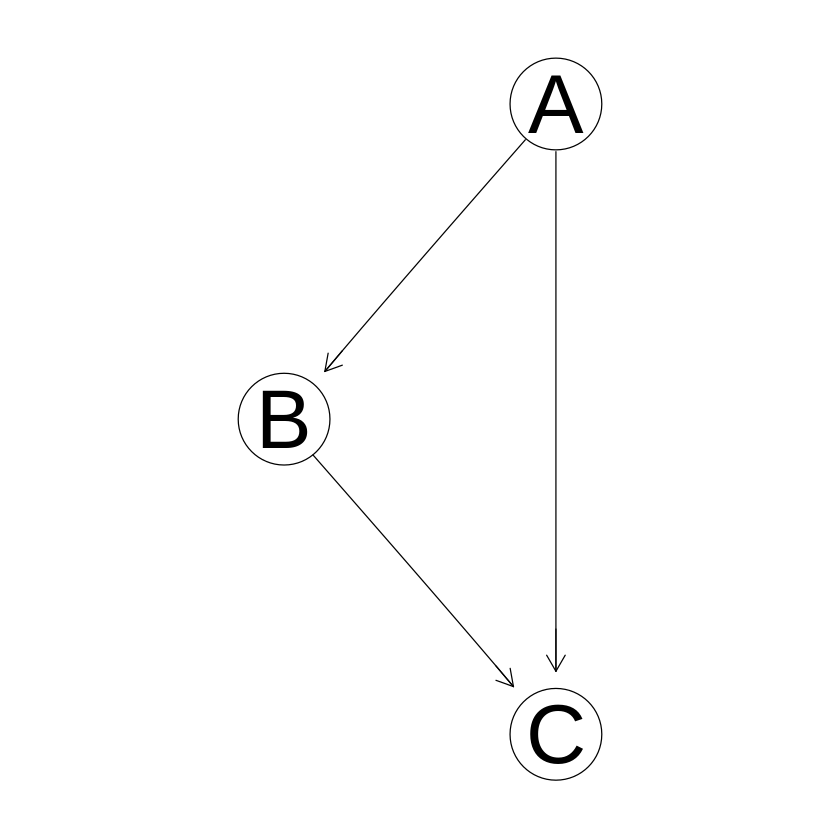

In [2]:
net <- model2network('[A][B|A][C|B:A]')
nombres <- c('off', 'on')
cptA <- matrix(c(0.5, 0.5), ncol=2)
dimnames(cptA) <- list(NULL, nombres)
cptB <- matrix(c(.8, .2, .1, .9), ncol=2)
dimnames(cptB) <- list(B = nombres, A = nombres)
cptC <- matrix(c(.9, .1, .99, .01, .1, .9, .4, .6))
dim(cptC) <- c(2, 2, 2)
dimnames(cptC) <- list(C = nombres, A = nombres, B = nombres)
model <- custom.fit(net, list(A = cptA, B = cptB, C = cptC))
graphviz.plot(model)

In [11]:
model$A


  Parameters of node A (multinomial distribution)

Conditional probability table:
 
off  on 
0.5 0.5 

In [12]:
model$B


  Parameters of node B (multinomial distribution)

Conditional probability table:
 
     A
B     off  on
  off 0.8 0.1
  on  0.2 0.9

In [13]:
model$C


  Parameters of node C (multinomial distribution)

Conditional probability table:
 
, , B = off

     A
C      off   on
  off 0.90 0.99
  on  0.10 0.01

, , B = on

     A
C      off   on
  off 0.10 0.40
  on  0.90 0.60


We want to calculate
`P (A|B, C) = P(C|B, A)P(B|A)P(A) / Sum_A(P (C|B, A)P(B|A)P(A))`

From probability table:
 ```
 P (C=on|B=on, A=on) = 0.6
 P(B=on|A=on) = 0.9
 P(A=on)  = 0.5
 
 P(C=on|B=on, A=on)P(B=on|A=on)P(A=on) = 0.27
 
 P(C=on|B=on, A=off)P(B=on|A=off)P(A=off) = 0.90  * 0.2  * 0.5 = 0.09
 Sum_A(P (C|B, A)P(B|A)P(A)) = 0.27 + 0.09 = 0.36
 
 P (A = on | B = on, C = on) = 0.27/0.36 = 0.75
 
 ```
 

3b)

In [15]:

samples <- rbn(model, n =50000)
samples_b_on_c_on <- subset(samples, (B == 'on' & C=='on'))


In [16]:

print(nrow(subset(samples_b_on_c_on, (A == 'on')))/nrow(samples_b_on_c_on))

[1] 0.7480524


P (A = on | B = on, C = on) calculated with rejection sampling is 0.75

3c)

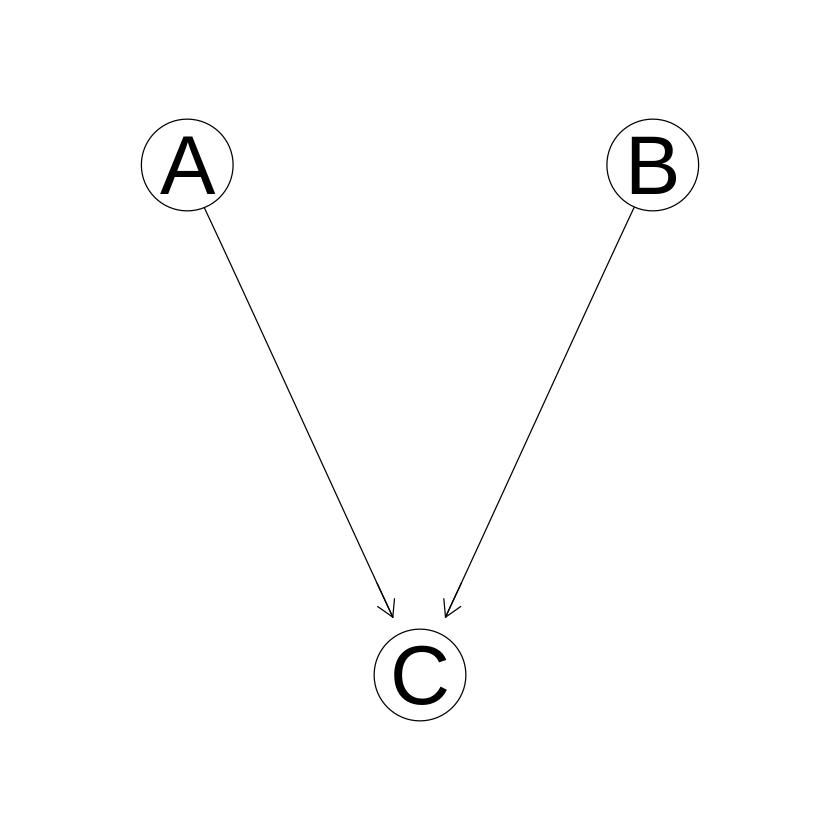

In [17]:
intervention_graph = mutilated(model, evidence = list(B = 'on'))
graphviz.plot(intervention_graph)

3d)

In [29]:
intervention_graph$A


  Parameters of node A (multinomial distribution)

Conditional probability table:
 
off  on 
0.5 0.5 

In [30]:
intervention_graph$B


  Parameters of node B (multinomial distribution)

Conditional probability table:
 off  on 
  0   1 

In [31]:
intervention_graph$C


  Parameters of node C (multinomial distribution)

Conditional probability table:
 
, , B = off

     A
C      off   on
  off 0.90 0.99
  on  0.10 0.01

, , B = on

     A
C      off   on
  off 0.10 0.40
  on  0.90 0.60


In [36]:
modelstring(intervention_graph)

[1] "[A][B][C|A:B]"

We want to calculate
`P (A = on | do(B = on), C = on) = p(A)P(B)P(C|A,B)/Sum_A(P (C|B, A)P(B)P(A))`

From probability table:
 ```
 P (C=on|B=on, A=on) = 0.6
 P(B=on) = 1
 P(A=on)  = 0.5
 p(A)P(B)P(C|A,B) = 0.30
 


P(C=on|B=on, A=off)P(B=on)P(A=off) = 0.90  * 1  * 0.5 = 0.45
 Sum_A(P (C|B, A)P(B|A)P(A)) = 0.30 + 0.45 = 0.75
 
 P (A = on | do(B = on), C = on) = 0.30/0.75 = 0.40
 ```

In [19]:
samples_intervention <- rbn(intervention_graph, n =50000)
samples_do_b_on_c_on <- subset(samples_intervention, (B == 'on' & C=='on'))
print(nrow(subset(samples_do_b_on_c_on, (A == 'on')))/nrow(samples_do_b_on_c_on))


[1] 0.4034943


P (A = on | do(B = on), C = on) calculated with rejection sampling is 0.40

In [4]:
dag <- empty.graph(nodes = c("A","S","E","O","R","T"))
arc.set <- matrix(c("A", "E",
                    "S", "E",
                    "E", "O",
                    "E", "R",
                    "O", "T",
                    "R", "T"),
                  byrow = TRUE, ncol = 2,
                  dimnames = list(NULL, c("from", "to")))
arcs(dag) <- arc.set
A.lv <- c("young", "adult", "old")
S.lv <- c("M", "F")
E.lv <- c("high", "uni")
O.lv <- c("emp", "self")
R.lv <- c("small", "big")
T.lv <- c("car", "train", "other")
A.prob <- array(c(0.3,0.5,0.2), dim = 3, dimnames = list(A = A.lv))
S.prob <- array(c(0.6,0.4), dim = 2, dimnames = list(S = S.lv))
E.prob <- array(c(0.75,0.25,0.72,0.28,0.88,0.12,0.64,0.36,0.70,0.30,0.90,0.10), dim = c(2,3,2), dimnames = list(E = E.lv, A = A.lv, S = S.lv))
O.prob <- array(c(0.96,0.04,0.92,0.08), dim = c(2,2), dimnames = list(O = O.lv, E = E.lv))
R.prob <- array(c(0.25,0.75,0.2,0.8), dim = c(2,2), dimnames = list(R = R.lv, E = E.lv))
T.prob <- array(c(0.48,0.42,0.10,0.56,0.36,0.08,0.58,0.24,0.18,0.70,0.21,0.09), dim = c(3,2,2), dimnames = list(T = T.lv, O = O.lv, R = R.lv))
cpt <- list(A = A.prob, S = S.prob, E = E.prob, O = O.prob, R = R.prob, T = T.prob)
bn <- custom.fit(dag, cpt)


In [8]:
bn$E


  Parameters of node E (multinomial distribution)

Conditional probability table:
 
, , S = M

      A
E      young adult  old
  high  0.75  0.72 0.88
  uni   0.25  0.28 0.12

, , S = F

      A
E      young adult  old
  high  0.64  0.70 0.90
  uni   0.36  0.30 0.10
